# Ultimate Data Challenge:
### This project is designed to test an individual's ability to work with a new data set and extract relevant information

The data is for a fake transportation company that contracts drivers to drive passengers around two major cities. There is a toll road connecting the two cities, and so very few drivers go from one city to another. The company is proposing reimbursing drivers for toll fees when shuttling passengers across. To determine if the experiment is successful, we could employ a simple t-test for pre- and post-reimbursement to determine if there is a significant increase in trips across the toll road. However, as drivers are currently averse to using the toll road, a statistically significant increase may not reflect a realistic significant increase. So we may want to propose an additional criteria for determining success, of perhaps a 100% increase (or double) use of the toll road with tolls reimbursed.

In addition, Ultimate is experiencing high driver turnover, and would like to identify key factors that contribute to the turnover. They would like this build into an ML code to be able to predict likelihood of an individual to leave before 6-months.

Before we dive into these deep questions though, let's first look at the login data and see if we can identify high demand times.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [2]:
l = open(r'C:\Users\benja\Dropbox\Ben Code\Springboard not GIT linked\ultimate_challenge\ultimate_challenge\logins.json')
u = open(r'C:\Users\benja\Dropbox\Ben Code\Springboard not GIT linked\ultimate_challenge\ultimate_challenge\ultimate_data_challenge.json')

logins = json.load(l)
data = json.load(u)

In [3]:
#Let's inspect the data a bit here
print(logins)

{'login_time': ['1970-01-01 20:13:18', '1970-01-01 20:16:10', '1970-01-01 20:16:37', '1970-01-01 20:16:36', '1970-01-01 20:26:21', '1970-01-01 20:21:41', '1970-01-01 20:12:16', '1970-01-01 20:35:47', '1970-01-01 20:35:38', '1970-01-01 20:47:52', '1970-01-01 20:26:05', '1970-01-01 20:31:03', '1970-01-01 20:34:46', '1970-01-01 20:36:34', '1970-01-01 20:39:25', '1970-01-01 20:40:37', '1970-01-01 20:34:58', '1970-01-01 20:43:59', '1970-01-01 20:47:46', '1970-01-01 20:46:34', '1970-01-01 20:56:07', '1970-01-01 20:49:12', '1970-01-01 20:59:06', '1970-01-01 20:59:59', '1970-01-01 21:15:01', '1970-01-01 21:09:24', '1970-01-01 21:19:24', '1970-01-01 21:20:53', '1970-01-01 21:29:19', '1970-01-01 21:58:05', '1970-01-01 21:51:51', '1970-01-01 21:59:40', '1970-01-01 22:08:34', '1970-01-01 22:02:51', '1970-01-01 21:58:32', '1970-01-01 22:02:31', '1970-01-01 22:05:32', '1970-01-01 22:02:46', '1970-01-01 22:10:28', '1970-01-01 22:11:58', '1970-01-01 22:01:05', '1970-01-01 22:19:10', '1970-01-01 22:16:

In [4]:
#JSON files upload typically as a dictionary, which is very convenient to covert to a pandas dataframe:
login_df = pd.DataFrame(logins)
print(login_df.head())
print(login_df.dtypes)

            login_time
0  1970-01-01 20:13:18
1  1970-01-01 20:16:10
2  1970-01-01 20:16:37
3  1970-01-01 20:16:36
4  1970-01-01 20:26:21
login_time    object
dtype: object


In [5]:
#We'll need to convert the data to date-time stamps to work with it more smoothly:
login_df['login_time'] = pd.to_datetime(login_df['login_time'])
print(login_df.head())
print(login_df.dtypes)

           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21
login_time    datetime64[ns]
dtype: object


In [6]:
#Next we'll create a count value (setting it to 1) for each login event to group over
login_df['count'] = 1
login_df['time'] = pd.to_datetime(login_df['login_time'], format = '%H:%M:%S').dt.time[0]
login_df['date'] = login_df['login_time'].dt.date
login_df.head()

,login_time,count,time,date
0,1970-01-01 20:13:18,1,20:13:18,1970-01-01
1,1970-01-01 20:16:10,1,20:13:18,1970-01-01
2,1970-01-01 20:16:37,1,20:13:18,1970-01-01
3,1970-01-01 20:16:36,1,20:13:18,1970-01-01
4,1970-01-01 20:26:21,1,20:13:18,1970-01-01


In [7]:
login_df['date'] = pd.to_datetime(login_df['date'])

In [8]:
login_df.dtypes

login_time    datetime64[ns]
count                  int64
time                  object
date          datetime64[ns]
dtype: object

In [9]:
login_df['day'] = login_df['date'].dt.day_name()
login_df.head()

,login_time,count,time,date,day
0,1970-01-01 20:13:18,1,20:13:18,1970-01-01,Thursday
1,1970-01-01 20:16:10,1,20:13:18,1970-01-01,Thursday
2,1970-01-01 20:16:37,1,20:13:18,1970-01-01,Thursday
3,1970-01-01 20:16:36,1,20:13:18,1970-01-01,Thursday
4,1970-01-01 20:26:21,1,20:13:18,1970-01-01,Thursday


In [10]:
login_df['time'] = login_df['login_time'].dt.time

In [11]:
#Next we'll create a new dataframe that has counts by every 15 minutes
grouped = login_df[['login_time', 'count']].groupby(pd.Grouper(key = 'login_time', freq = '15min')).count()
grouped.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [12]:
grouped['time'] = grouped.index.time
grouped.head()

,count,time
login_time,,
1970-01-01 20:00:00,2,20:00:00
1970-01-01 20:15:00,6,20:15:00
1970-01-01 20:30:00,9,20:30:00
1970-01-01 20:45:00,7,20:45:00
1970-01-01 21:00:00,1,21:00:00


In [13]:
grouped.dtypes

count     int64
time     object
dtype: object

In [14]:
#Next we'll create a new dataframe that has counts by the hour to visualize
grouped_hour = login_df[['login_time', 'count']].groupby(pd.Grouper(key = 'login_time', freq = '1H')).count()
grouped_hour.head()

,count
login_time,
1970-01-01 20:00:00,24
1970-01-01 21:00:00,9
1970-01-01 22:00:00,21
1970-01-01 23:00:00,58
1970-01-02 00:00:00,53


In [15]:
grouped_hour['time'] = grouped_hour.index.time
grouped_hour.head()

,count,time
login_time,,
1970-01-01 20:00:00,24,20:00:00
1970-01-01 21:00:00,9,21:00:00
1970-01-01 22:00:00,21,22:00:00
1970-01-01 23:00:00,58,23:00:00
1970-01-02 00:00:00,53,00:00:00


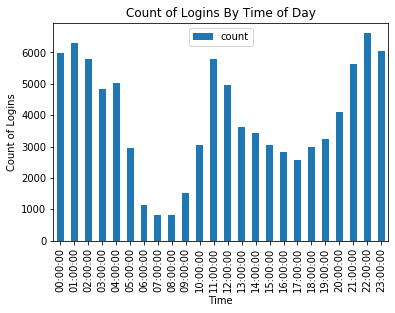

In [16]:
#Great! We have our counts of logins for each 15 minute interval, let's make a histogram and see when the major peaks are.
#The data is still pretty lengthy grouped by 15 minute intervals, so to make it more readable I'm going to limit 
grouped_hour[['count','time']].groupby('time').sum().plot(kind='bar')
plt.xlabel('Time')
plt.ylabel('Count of Logins')
plt.title('Count of Logins By Time of Day')
plt.show()

#### Wow, so looks like there's a big lunch rush and a steady use at night starting at about 9 PM

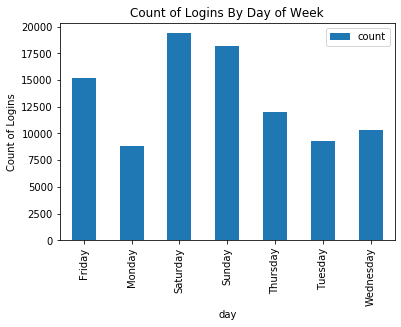

In [17]:
#Next let's see what days of the week have the highest counts of logins
#login_df.plot.bar(x = 'day', y = np.sum('count'))
login_df[['count','day']].groupby('day').sum().plot(kind='bar')
plt.ylabel('Count of Logins')
plt.title('Count of Logins By Day of Week')
plt.show()

#### Neat! So looks like Saturdays are the most used followed closely by Sunday, then Friday, and Mondays see the least use. 
#### Next let's take a look at the Ultimate data set and see what we can examine about reimbursing toll fees

In [18]:
#We'll start by taking a peak at the raw json data as it was imported
print(data[:5])

[{'city': "King's Landing", 'trips_in_first_30_days': 4, 'signup_date': '2014-01-25', 'avg_rating_of_driver': 4.7, 'avg_surge': 1.1, 'last_trip_date': '2014-06-17', 'phone': 'iPhone', 'surge_pct': 15.4, 'ultimate_black_user': True, 'weekday_pct': 46.2, 'avg_dist': 3.67, 'avg_rating_by_driver': 5.0}, {'city': 'Astapor', 'trips_in_first_30_days': 0, 'signup_date': '2014-01-29', 'avg_rating_of_driver': 5.0, 'avg_surge': 1.0, 'last_trip_date': '2014-05-05', 'phone': 'Android', 'surge_pct': 0.0, 'ultimate_black_user': False, 'weekday_pct': 50.0, 'avg_dist': 8.26, 'avg_rating_by_driver': 5.0}, {'city': 'Astapor', 'trips_in_first_30_days': 3, 'signup_date': '2014-01-06', 'avg_rating_of_driver': 4.3, 'avg_surge': 1.0, 'last_trip_date': '2014-01-07', 'phone': 'iPhone', 'surge_pct': 0.0, 'ultimate_black_user': False, 'weekday_pct': 100.0, 'avg_dist': 0.77, 'avg_rating_by_driver': 5.0}, {'city': "King's Landing", 'trips_in_first_30_days': 9, 'signup_date': '2014-01-10', 'avg_rating_of_driver': 4.

In [19]:
#OK, so it looks like all of this data is records of riders for Ultimate, let's convert it to a dataframe for easier use:
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [20]:
#Next let's see if we have any missing data:
print(df.isnull().any())
print(df.isnull().any().count())

city                      False
trips_in_first_30_days    False
signup_date               False
avg_rating_of_driver       True
avg_surge                 False
last_trip_date            False
phone                      True
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver       True
dtype: bool
12


In [21]:
#OK, so we have 12 drivers who have missing data. It looks like that is exclusively the drivers' ratings, phone type, and 
#their ratings given. I think the best thing to do here is to simply remove this data as we don't have an effective method of
#filling it in.

df = df.dropna()

In [22]:
df.isnull().any()

city                      False
trips_in_first_30_days    False
signup_date               False
avg_rating_of_driver      False
avg_surge                 False
last_trip_date            False
phone                     False
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver      False
dtype: bool

In [23]:
#Let's examine the data a bit here, we'll look at some basic summary statistics of our data set and make a couple bar plots
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000
mean,2.609675,4.601720,1.073822,8.898709,61.254897,5.460046,4.776446
std,4.059336,0.616104,0.198747,18.322061,34.813848,5.145174,0.404606
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,37.500000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.780000,5.000000
75%,3.000000,5.000000,1.070000,11.100000,100.000000,6.490000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,79.690000,5.000000


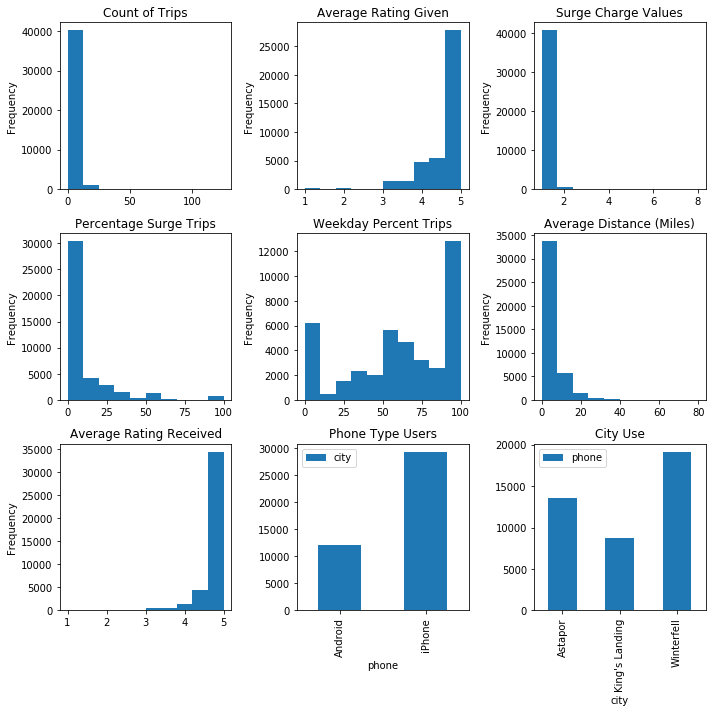

In [24]:
#OK, so it looks like most drivers and passengers are fairly well rated, surge charges are on average pretty low,
#and over half the trips (61%) were on weekdays. Let's look at the distributions

fig, axes = plt.subplots(3,3)
fig.set_size_inches(10, 10)

df['trips_in_first_30_days'].plot(ax = axes[0,0], kind = 'hist', bins = 10)
axes[0,0].set_title('Count of Trips')
df['avg_rating_of_driver'].plot(ax = axes[0,1], kind = 'hist', bins = 10)
axes[0,1].set_title('Average Rating Given')
df['avg_surge'].plot(ax = axes[0,2], kind = 'hist', bins = 10)
axes[0,2].set_title('Surge Charge Values')
df['surge_pct'].plot(ax = axes[1,0], kind = 'hist', bins = 10)
axes[1,0].set_title('Percentage Surge Trips')
df['weekday_pct'].plot(ax = axes[1,1], kind = 'hist', bins = 10)
axes[1,1].set_title('Weekday Percent Trips')
df['avg_dist'].plot(ax = axes[1,2], kind = 'hist', bins = 10)
axes[1,2].set_title('Average Distance (Miles)')
df['avg_rating_by_driver'].plot(ax = axes[2,0], kind = 'hist', bins = 10)
axes[2,0].set_title('Average Rating Received')
df[['city', 'phone']].groupby('phone').count().plot(ax = axes[2,1], kind = 'bar')
axes[2,1].set_title('Phone Type Users')
df[['city', 'phone']].groupby('city').count().plot(ax = axes[2,2], kind = 'bar')
axes[2,2].set_title('City Use')
plt.tight_layout()
plt.show()

#### OK, so a lot of our data is skewed, but that's not terribly surprising given the types of data. Because we'll be scaling the data to create a predictive model of what indicates a user will stick with Ultimate, I'm not concerned about the non-normality of the data. Also, it looks like a lot of people use Ultimate exclusively on weekdays.

In [25]:
#We'll need some new columns, one to identify long-term users (i.e. longer than 6-months), 
#and one to identify current users (i.e. in the last 30 days)
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [26]:
#Note here I'm using the last recorded trip date as 'current date' because the last trip was in 2014
df['days_since_last_login'] = ((df.last_trip_date.max() - df.last_trip_date)/np.timedelta64(1, "D"))
df['days_since_last_login'] = df['days_since_last_login'].astype(int)

df['current_user'] = df['days_since_last_login'].apply(lambda x: x <= 30)
        
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,days_since_last_login,current_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,14,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,57,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,175,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,108,False


In [27]:
#Calculate long-term users
df['months_user'] = ((df.last_trip_date - df.signup_date)/np.timedelta64(1, "M"))
df['months_user'] = df['months_user'].astype(int)

df['long_term_user'] = df['months_user'].apply(lambda x: x >= 5)

df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,days_since_last_login,current_user,months_user,long_term_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,14,True,4,False
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,57,False,3,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,175,False,0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2,True,5,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,108,False,1,False


In [28]:
total_current_users = np.sum(df['current_user'])
print('Total Current User Count: ' + str(total_current_users))
total_long_term_users = np.sum(df['long_term_user'])
print('Total Long-term User Count: ' + str(total_long_term_users))

Total Current User Count: 17035
Total Long-term User Count: 10342


In [29]:
#split data into training and testing
y = df['long_term_user']
x = df.drop(['long_term_user', 'signup_date', 'last_trip_date', 'months_user'], axis = 1)

x = pd.get_dummies(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 123)

In [30]:
#Begin building pipe for random forest model
#RF_pipe = make_pipeline(
#    StandardScaler(),
#    RandomForestClassifier(n_estimators = 100))

clf = RandomForestClassifier(n_estimators = 100)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8982989504162142


In [31]:
feature_imp = pd.Series(clf.feature_importances_, index = x.columns.tolist()).sort_values(ascending = False)
feature_imp

days_since_last_login     0.413656
current_user              0.205498
avg_dist                  0.080682
weekday_pct               0.057836
surge_pct                 0.047075
avg_rating_by_driver      0.042329
trips_in_first_30_days    0.039192
avg_rating_of_driver      0.036631
avg_surge                 0.034016
ultimate_black_user       0.011751
city_King's Landing       0.008172
phone_iPhone              0.006306
phone_Android             0.006147
city_Astapor              0.005471
city_Winterfell           0.005239
dtype: float64

No handles with labels found to put in legend.


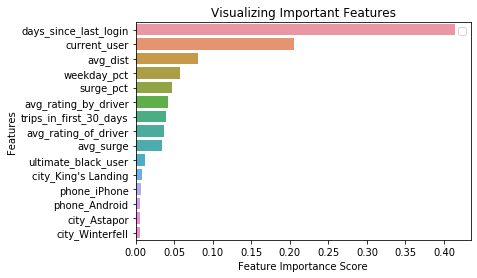

In [32]:
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

#### Wow, so how long it's been since someone logged in, and, similarly, whether someone's a current user are very important in predicting whether someone is a long-term user.

In [33]:
l.close()
u.close()